In [16]:
from transformers import AutoImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests 

In [4]:
train_json = json.load(open('newestEMOTIC_train_x1y1x2y2.json'))
train_json["annotations"]

[{'image_id': 0,
  'id': 0,
  'category_id': 1,
  'bbox': [104.82514190673828,
   79.68680572509766,
   705.2232055664062,
   796.4976196289062],
  'coco_ids': {'image_id': 562243, 'annotations_id': 448867},
  'annotations_categories': None,
  'annotations_continuous': {'valence': 5, 'arousal': 3, 'dominance': 9},
  'gender': 'Male',
  'age': 'Adult'},
 {'image_id': 0,
  'id': 1,
  'category_id': 1,
  'bbox': [86, 58, 564, 628],
  'coco_ids': {'image_id': 562243, 'annotations_id': 448867},
  'annotations_categories': ['Disconnection', 'Doubt/Confusion'],
  'annotations_continuous': {'valence': 5, 'arousal': 3, 'dominance': 9},
  'gender': 'Male',
  'age': 'Adult'},
 {'image_id': 1,
  'id': 2,
  'category_id': 1,
  'bbox': [558.676025390625,
   853.2855224609375,
   680.642822265625,
   1065.6998291015625],
  'coco_ids': {'image_id': 288841, 'annotations_id': 1750456},
  'annotations_categories': None,
  'annotations_continuous': {'valence': 6, 'arousal': 4, 'dominance': 7},
  'gender':

In [9]:
from collections import Counter

image_ids = [item['image_id'] for item in train_json["annotations"]]
occurrences = Counter(image_ids)

df_occurrences = pd.DataFrame({'image_id': list(occurrences.keys()), 'occurrences': list(occurrences.values())})
print(df_occurrences)

print(max(df_occurrences['occurrences']))

max_occurrence_image_id = df_occurrences['image_id'].loc[df_occurrences['occurrences'].idxmax()]
print(max_occurrence_image_id)


       image_id  occurrences
0             0            2
1             1           10
2             2            4
3             3            2
4             4           12
...         ...          ...
17003     17072           27
17004     17073            3
17005     17074            2
17006     17075           11
17007     17076           24

[17008 rows x 2 columns]
196
11095


In [12]:
train_json["images"]
image_id = 11095
image = [item for item in train_json["images"] if item["id"] == image_id]
print(image)


[{'database': 'EMOTIC', 'file_name': '4m7t3bsqtw1upazkri.jpg', 'folder': 'emodb_small/images', 'name': 'emodb_small', 'height': 1339, 'width': 2000, 'id': 11095, 'coco_ids': []}]


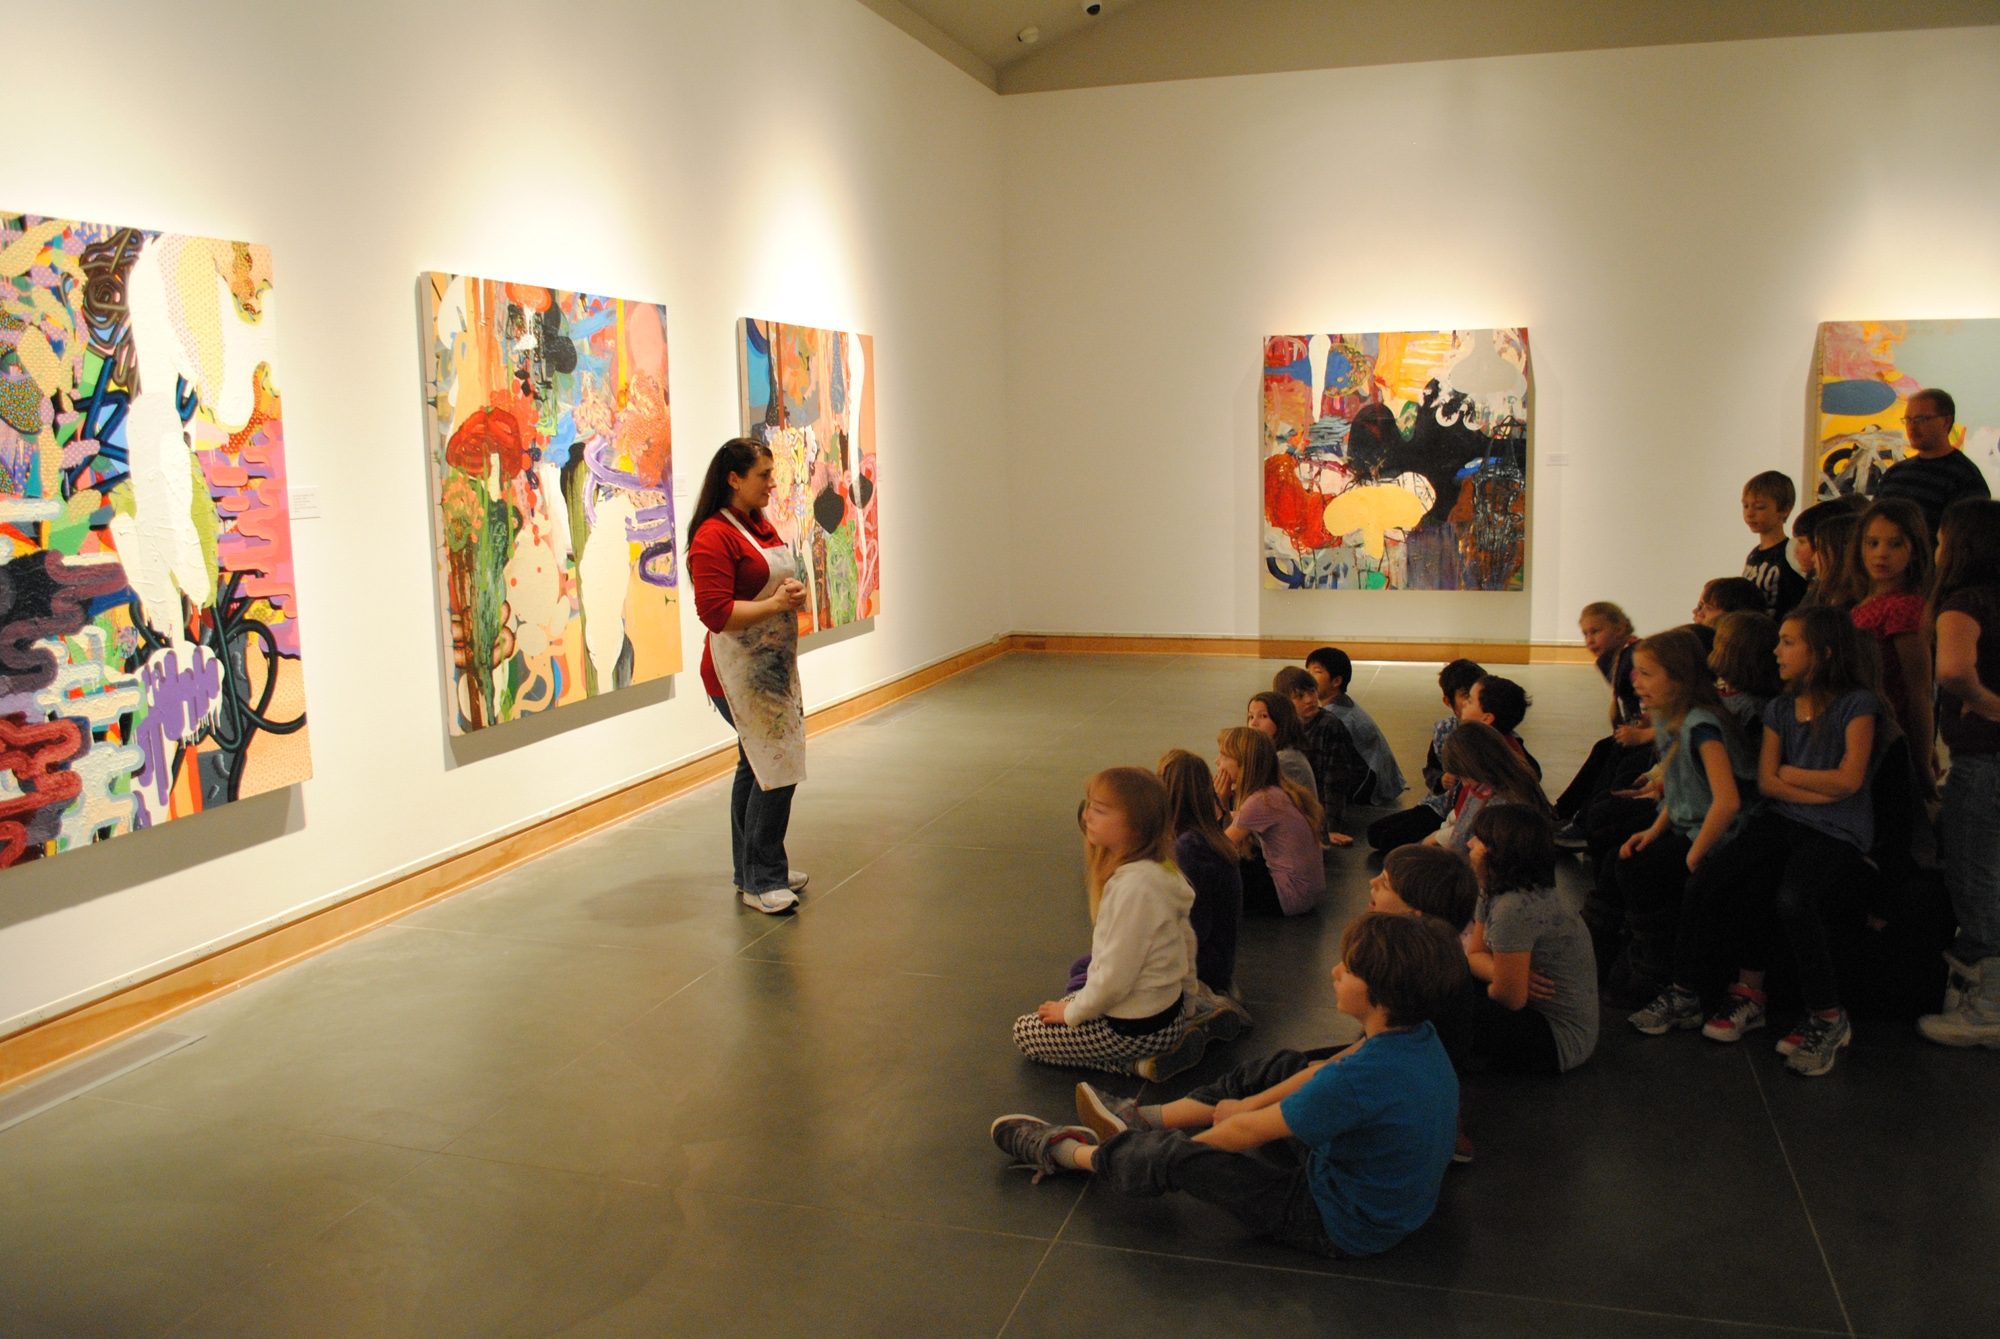

In [13]:
from IPython.display import Image

path = "./EMOTIC (1)/EMOTIC/PAMI/emotic/emodb_small/images/4m7t3bsqtw1upazkri.jpg"
Image(filename=path)


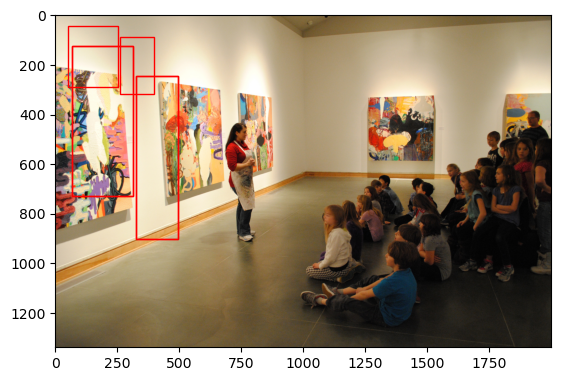

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define the path to the image
path = "./EMOTIC (1)/EMOTIC/PAMI/emotic/emodb_small/images/4m7t3bsqtw1upazkri.jpg"

# Load and display the image
image = plt.imread(path)
plt.imshow(image)

# Get the annotations for the specified image_id
image_id = 11905
annotations = [item for item in train_json["annotations"] if item["image_id"] == image_id]

# Plot the bounding boxes on the image
for annotation in annotations:
    x1, y1, x2, y2 = annotation['bbox']
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)

# Show the image with annotations
plt.show()


In [17]:
url = "EMOTIC (1)\EMOTIC\PAMI\emotic\emodb_small\images/0crce5soni30mrvq7t.jpg"
url = url.replace("\\", "/")

image = Image.open(url)

image_processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

inputs = image_processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[0]


for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
c:\Users\JALAL\anaconda3\Lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encode

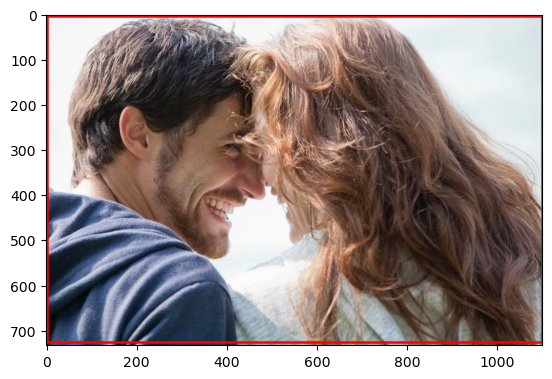

In [20]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


# Load and display the image
image = plt.imread(url)
plt.imshow(image)

# Get the annotations for the specified image_id
image_id = 11905
annotations = [item for item in train_json["annotations"] if item["image_id"] == image_id]

# Plot the bounding boxes on the image
for annotation in annotations:
    x1, y1, x2, y2 = box
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)

# Show the image with annotations
plt.show()
